# CSC180 Project 2
## by Yahir Ocegueda
## 10/09/2024

### <font color='red'><b>Importing necessary tools and setting up functions</b></font>

In [2]:
from collections.abc import Sequence
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing
from sklearn import svm, datasets
from sklearn.metrics import f1_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

## Data Preprocessing

### <font color='red'><b>Loading in training dataset</b></font>

In [4]:
train_df = pd.read_csv('UNSW_NB15_training-set.csv', na_values=['-'])
train_df[0:10]

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,NaN,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,NaN,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,NaN,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,NaN,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0
5,6,0.380537,tcp,NaN,FIN,10,6,534,268,39.417980,...,1,40,0,0,0,2,39,0,Normal,0
6,7,0.637109,tcp,NaN,FIN,10,8,534,354,26.683033,...,1,40,0,0,0,1,39,0,Normal,0
7,8,0.521584,tcp,NaN,FIN,10,8,534,354,32.593026,...,1,40,0,0,0,3,39,0,Normal,0
8,9,0.542905,tcp,NaN,FIN,10,8,534,354,31.313031,...,1,40,0,0,0,3,39,0,Normal,0
9,10,0.258687,tcp,NaN,FIN,10,6,534,268,57.985135,...,1,40,0,0,0,3,39,0,Normal,0


### <font color='red'><b>Loading in testing dataset</b></font>

In [5]:
test_df = pd.read_csv('UNSW_NB15_test-set.csv', na_values=['-'])
test_df[0:10]

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,NaN,INT,2,0,496,0,90909.09020,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,NaN,INT,2,0,1762,0,125000.00030,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,NaN,INT,2,0,1068,0,200000.00510,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,NaN,INT,2,0,900,0,166666.66080,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,NaN,INT,2,0,2126,0,100000.00250,...,1,3,0,0,0,2,3,0,Normal,0
5,6,0.000003,udp,NaN,INT,2,0,784,0,333333.32150,...,1,2,0,0,0,2,2,0,Normal,0
6,7,0.000006,udp,NaN,INT,2,0,1960,0,166666.66080,...,1,2,0,0,0,2,2,0,Normal,0
7,8,0.000028,udp,NaN,INT,2,0,1384,0,35714.28522,...,1,3,0,0,0,1,3,0,Normal,0
8,9,0.000000,arp,NaN,INT,1,0,46,0,0.00000,...,2,2,0,0,0,2,2,1,Normal,0
9,10,0.000000,arp,NaN,INT,1,0,46,0,0.00000,...,2,2,0,0,0,2,2,1,Normal,0


In [6]:
print(train_df.shape)
print(test_df.shape)

(175341, 45)
(82332, 45)


### <font color='red'><b>Dropping records with missing values</b></font>

In [7]:
train_df = train_df.dropna()
test_df = test_df.dropna()

print(train_df.shape)
print(test_df.shape)

(81173, 45)
(35179, 45)


### <font color='red'><b>Dropping the id column</b></font>

In [8]:
train_df.drop('id', axis=1, inplace=True)
test_df.drop('id', axis=1, inplace=True)

### <font color='red'><b>Normalizing data</b></font>

In [9]:
columns_not_to_normalize = ['attack_cat', 'proto', 'service', 'state', 'is_ftp_login', 'is_sm_ips_ports', 'label']
columns_to_normalize = train_df.columns.difference(columns_not_to_normalize)
print(len(columns_to_normalize))
columns_to_normalize

37


Index(['ackdat', 'ct_dst_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'ct_flw_http_mthd', 'ct_ftp_cmd', 'ct_src_dport_ltm', 'ct_src_ltm',
       'ct_srv_dst', 'ct_srv_src', 'ct_state_ttl', 'dbytes', 'dinpkt', 'djit',
       'dload', 'dloss', 'dmean', 'dpkts', 'dtcpb', 'dttl', 'dur', 'dwin',
       'rate', 'response_body_len', 'sbytes', 'sinpkt', 'sjit', 'sload',
       'sloss', 'smean', 'spkts', 'stcpb', 'sttl', 'swin', 'synack', 'tcprtt',
       'trans_depth'],
      dtype='object')

In [10]:
# Loop through each column that needs to be normalized
for column in columns_to_normalize:
  train_df[column] = zscore(train_df[column])
  test_df[column] = zscore(test_df[column])

In [11]:
train_df[0:10]

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
3,0.174678,tcp,ftp,FIN,-0.048030,-0.044580,-0.055932,-0.077783,-0.624127,-1.042533,...,-0.89029,-0.790893,1,5.266800,-0.278275,-0.855609,-0.927303,0,Normal,0
11,0.266081,tcp,smtp,FIN,0.216766,0.076681,0.169686,-0.069496,-0.623959,-1.042533,...,-0.89029,-0.865260,0,-0.175734,-0.278275,-0.955810,-0.927303,0,Normal,0
15,-0.198901,udp,snmp,INT,-0.100989,-0.135525,-0.057917,-0.082207,2.287063,0.822651,...,-0.89029,-0.716527,0,-0.175734,-0.278275,-0.855609,-0.927303,0,Normal,0
17,-0.111473,tcp,http,FIN,-0.058622,-0.074895,-0.054992,-0.075909,-0.623955,-1.042533,...,-0.89029,-0.865260,0,-0.175734,0.719269,-0.955810,-0.778754,0,Normal,0
21,-0.123811,tcp,http,FIN,-0.058622,-0.090053,-0.054433,-0.080667,-0.623949,0.822651,...,-0.89029,-0.939626,0,-0.175734,0.719269,-0.855609,-0.778754,0,Normal,0
22,0.015398,tcp,ftp,CON,-0.037438,-0.044580,-0.055681,-0.076748,-0.624056,-1.042533,...,-0.89029,-0.865260,1,5.266800,-0.278275,-0.855609,-0.927303,0,Normal,0
28,-0.077513,tcp,http,FIN,-0.058622,-0.074895,-0.053745,-0.076231,-0.624026,0.822651,...,-0.89029,-0.865260,0,-0.175734,0.719269,-0.955810,-0.407380,0,Normal,0
30,-0.037621,tcp,http,FIN,-0.058622,-0.014265,-0.055146,-0.011986,-0.624006,-1.042533,...,-0.89029,-0.865260,0,-0.175734,0.719269,-0.855609,-0.927303,0,Normal,0
31,-0.137898,tcp,http,FIN,-0.058622,-0.090053,-0.053502,-0.080667,-0.623889,-1.042533,...,-0.89029,-0.716527,0,-0.175734,0.719269,-0.955810,-0.407380,0,Normal,0
32,-0.123935,tcp,http,FIN,-0.058622,-0.074895,-0.055235,-0.069220,-0.623914,-1.042533,...,-0.89029,-0.939626,0,-0.175734,0.719269,-0.955810,-0.407380,0,Normal,0


In [12]:
test_df[0:10]

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
35,0.151353,tcp,http,FIN,-0.044028,-0.056242,-0.047047,-0.063537,-0.654855,-1.100636,...,-0.700427,-0.666208,0,-0.139398,0.739098,-0.778396,-0.707906,0,Normal,0
40,0.357155,tcp,http,FIN,-0.044028,-0.041793,-0.047000,-0.063025,-0.654886,-1.100636,...,-0.700427,-0.666208,0,-0.139398,0.739098,-0.778396,-0.707906,0,Normal,0
45,0.179528,tcp,http,FIN,-0.044028,-0.056242,-0.046981,-0.063744,-0.654863,-1.100636,...,-0.700427,-0.732642,0,-0.139398,0.739098,-0.601013,-0.845030,0,Normal,0
49,0.153844,tcp,http,FIN,-0.044028,-0.041793,-0.047103,-0.062219,-0.654843,-1.100636,...,-0.700427,-0.666208,0,-0.139398,0.739098,-0.778396,-0.776468,0,Normal,0
72,0.270660,tcp,http,FIN,-0.031872,-0.056242,-0.046665,-0.063820,-0.654872,-1.100636,...,-0.700427,-0.732642,0,-0.139398,0.739098,-0.689704,-0.845030,0,Normal,0
89,0.686412,tcp,http,FIN,-0.031872,-0.041793,-0.046674,-0.063700,-0.654909,-1.100636,...,-0.700427,-0.732642,0,-0.139398,0.739098,-0.778396,-0.845030,0,Normal,0
99,0.522948,tcp,http,FIN,-0.044028,-0.041793,-0.047075,-0.063232,-0.654903,-1.100636,...,-0.700427,-0.666208,0,-0.139398,0.739098,-0.778396,-0.776468,0,Normal,0
116,0.358405,tcp,http,FIN,-0.044028,-0.041793,-0.047056,-0.063025,-0.654886,-1.100636,...,-0.700427,-0.666208,0,-0.139398,0.739098,-0.689704,-0.776468,0,Normal,0
130,0.390759,tcp,http,FIN,-0.031872,-0.056242,-0.046767,-0.063483,-0.654890,-1.100636,...,-0.700427,-0.732642,0,-0.139398,0.739098,-0.778396,-0.845030,0,Normal,0
135,0.175525,tcp,http,FIN,-0.044028,-0.056242,-0.047009,-0.063352,-0.654862,-1.100636,...,-0.700427,-0.533341,0,-0.139398,0.739098,-0.778396,-0.639344,0,Normal,0


In [13]:
print(train_df.shape)
print(test_df.shape)

(81173, 44)
(35179, 44)


### <font color='red'><b>Removing uncommon categorical values</b></font>

In [14]:
# List columns that contain categorical data
categorical_columns = ['proto', 'service', 'state', 'attack_cat']

train_unique_dict = {}
test_unique_dict = {}
common_values_dict = {}

# Loop through each categorical column
for column in categorical_columns:
    train_unique_values = set(train_df[column].unique())
    test_unique_values = set(test_df[column].unique())

    train_unique_dict[column] = train_unique_values
    test_unique_dict[column] = test_unique_values

    # Find the common values between the training and test sets for the current column
    common_values = train_unique_values.intersection(test_unique_values)

    common_values_dict[column] = common_values

    # Filter the training and test sets to include only rows with the common values for this column
    train_df = train_df[train_df[column].isin(common_values)]
    test_df = test_df[test_df[column].isin(common_values)]

print("Train unique values for each column:", train_unique_dict)
print("\nTest unique values for each column:", test_unique_dict)
print("\nCommon values for each column:", common_values_dict)

Train unique values for each column: {'proto': {'tcp', 'udp'}, 'service': {'irc', 'ssh', 'smtp', 'http', 'pop3', 'ftp', 'ssl', 'snmp', 'dns', 'dhcp', 'radius', 'ftp-data'}, 'state': {'INT', 'RST', 'REQ', 'CON', 'FIN'}, 'attack_cat': {'Exploits', 'Normal', 'Backdoor', 'Worms', 'Generic', 'Fuzzers', 'DoS', 'Reconnaissance', 'Analysis'}}

Test unique values for each column: {'proto': {'tcp', 'udp'}, 'service': {'irc', 'ssh', 'pop3', 'http', 'smtp', 'ftp', 'ssl', 'snmp', 'dns', 'dhcp', 'radius', 'ftp-data'}, 'state': {'INT', 'ACC', 'REQ', 'CON', 'FIN'}, 'attack_cat': {'Exploits', 'Normal', 'Backdoor', 'Generic', 'Fuzzers', 'DoS', 'Reconnaissance', 'Worms'}}

Common values for each column: {'proto': {'tcp', 'udp'}, 'service': {'ssh', 'pop3', 'smtp', 'http', 'ftp', 'ssl', 'snmp', 'dns', 'dhcp', 'irc', 'radius', 'ftp-data'}, 'state': {'INT', 'REQ', 'CON', 'FIN'}, 'attack_cat': {'Exploits', 'Normal', 'Backdoor', 'Generic', 'Fuzzers', 'DoS', 'Reconnaissance', 'Worms'}}


### <font color='red'><b>Encoding categorical features</b></font>

In [15]:
columns_to_encode = ['proto', 'service', 'state']

for column in columns_to_encode:
  encode_text_dummy(train_df, column)
  encode_text_dummy(test_df, column)

In [16]:
print(len(train_df))
print(len(test_df))

80595
35178


In [17]:
train_df

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,service-pop3,service-radius,service-smtp,service-snmp,service-ssh,service-ssl,state-CON,state-FIN,state-INT,state-REQ
3,0.174678,-0.048030,-0.044580,-0.055932,-0.077783,-0.624127,-1.042533,1.554597,-0.610105,-0.216535,...,False,False,False,False,False,False,False,True,False,False
11,0.266081,0.216766,0.076681,0.169686,-0.069496,-0.623959,-1.042533,1.554597,-0.607525,-0.211839,...,False,False,True,False,False,False,False,True,False,False
15,-0.198901,-0.100989,-0.135525,-0.057917,-0.082207,2.287063,0.822651,-0.717587,2.795858,-0.219824,...,False,False,False,True,False,False,False,False,True,False
17,-0.111473,-0.058622,-0.074895,-0.054992,-0.075909,-0.623955,-1.042533,1.554597,-0.609945,-0.200731,...,False,False,False,False,False,False,False,True,False,False
21,-0.123811,-0.058622,-0.090053,-0.054433,-0.080667,-0.623949,0.822651,1.554597,-0.609876,-0.214632,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175335,-0.198900,-0.100989,-0.135525,-0.058014,-0.082207,0.346216,0.822651,-0.717587,0.327744,-0.219824,...,False,False,False,False,False,False,False,False,True,False
175336,-0.198900,-0.100989,-0.135525,-0.058014,-0.082207,0.022742,0.822651,-0.717587,0.015117,-0.219824,...,False,False,False,False,False,False,False,False,True,False
175338,-0.198900,-0.100989,-0.135525,-0.058014,-0.082207,0.022742,0.822651,-0.717587,0.015117,-0.219824,...,False,False,False,False,False,False,False,False,True,False
175339,-0.198900,-0.100989,-0.135525,-0.058014,-0.082207,0.022742,0.822651,-0.717587,0.015117,-0.219824,...,False,False,False,False,False,False,False,False,True,False


In [18]:
test_df

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,service-pop3,service-radius,service-smtp,service-snmp,service-ssh,service-ssl,state-CON,state-FIN,state-INT,state-REQ
35,0.151353,-0.044028,-0.056242,-0.047047,-0.063537,-0.654855,-1.100636,1.574395,-0.636446,-0.198251,...,False,False,False,False,False,False,False,True,False,False
40,0.357155,-0.044028,-0.041793,-0.047000,-0.063025,-0.654886,-1.100636,1.574395,-0.636474,-0.201151,...,False,False,False,False,False,False,False,True,False,False
45,0.179528,-0.044028,-0.056242,-0.046981,-0.063744,-0.654863,-1.100636,1.574395,-0.636451,-0.199270,...,False,False,False,False,False,False,False,True,False,False
49,0.153844,-0.044028,-0.041793,-0.047103,-0.062219,-0.654843,-1.100636,1.574395,-0.636448,-0.195911,...,False,False,False,False,False,False,False,True,False,False
72,0.270660,-0.031872,-0.056242,-0.046665,-0.063820,-0.654872,-1.100636,1.574395,-0.636458,-0.201062,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81462,0.089544,0.259855,-0.012895,0.266900,-0.066586,-0.654406,0.790668,1.574395,-0.627894,-0.201607,...,False,False,False,False,False,False,False,True,False,False
81466,0.092117,0.259855,-0.012895,0.266900,-0.066586,-0.654411,0.790668,1.574395,-0.627966,-0.201663,...,False,False,False,False,False,False,False,True,False,False
81518,0.110694,0.259855,-0.012895,0.266900,-0.066586,-0.654443,0.790668,1.574395,-0.628453,-0.202042,...,False,False,False,False,False,False,False,True,False,False
81540,0.060414,0.259855,-0.012895,0.266900,-0.066586,-0.654348,0.790668,1.574395,-0.626984,-0.200899,...,False,False,False,False,False,False,False,True,False,False


### <font color='red'><b>Splitting data</b></font>

In [19]:
x_train, y_train = to_xy(train_df.drop('attack_cat', axis=1), 'label')
x_test, y_test = to_xy(test_df.drop('attack_cat', axis=1), 'label')

In [20]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(80595, 57)
(80595, 2)
(35178, 57)
(35178, 2)


# Models

## DNN Relu with adam optimizer

In [21]:
# Saving best model
saved_path = './Prj2Models/'
checkpointer = ModelCheckpoint(filepath=os.path.join(saved_path, "dnn_relu_adam_model.keras"), 
                               verbose=0, save_best_only=True)

# Run for 3 times
for i in range(3):
    print('\nRun: ', i + 1)
    dnn_relu_adam_model = Sequential()
    dnn_relu_adam_model.add(Dense(60, input_dim=x_train.shape[1], activation='relu')) # layer with activation relu
    dnn_relu_adam_model.add(Dense(30, activation='relu')) # added layer 
    dnn_relu_adam_model.add(Dense(y_train.shape[1], activation='softmax')) # output layer with softmax function
    
    # Compile using adam optimizer
    dnn_relu_adam_model.compile(loss='categorical_crossentropy', optimizer='adam')

    # Stop training when model stops improving
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')

    dnn_relu_adam_model.fit(x_train, y_train, validation_data=(x_test, y_test), callbacks=[monitor, checkpointer], verbose=2, epochs=1000)
    
print('Runs complete, saving model')  
print()
dnn_relu_adam_model.load_weights(os.path.join(saved_path, 'dnn_relu_adam_model.keras'))


Run:  1
Epoch 1/1000


/Users/yahir/anaconda3/envs/testenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2519/2519 - 2s - 685us/step - loss: 0.0577 - val_loss: 0.0927
Epoch 2/1000
2519/2519 - 1s - 469us/step - loss: 0.0432 - val_loss: 0.0934
Epoch 3/1000
2519/2519 - 1s - 471us/step - loss: 0.0401 - val_loss: 0.0803
Epoch 4/1000
2519/2519 - 1s - 462us/step - loss: 0.0383 - val_loss: 0.0987
Epoch 5/1000
2519/2519 - 1s - 464us/step - loss: 0.0372 - val_loss: 0.1316
Epoch 6/1000
2519/2519 - 1s - 467us/step - loss: 0.0365 - val_loss: 0.0766
Epoch 7/1000
2519/2519 - 1s - 464us/step - loss: 0.0356 - val_loss: 0.0800
Epoch 8/1000
2519/2519 - 1s - 577us/step - loss: 0.0347 - val_loss: 0.0798
Epoch 9/1000
2519/2519 - 1s - 466us/step - loss: 0.0342 - val_loss: 0.0803
Epoch 9: early stopping

Run:  2
Epoch 1/1000
2519/2519 - 2s - 662us/step - loss: 0.0598 - val_loss: 0.0841
Epoch 2/1000
2519/2519 - 1s - 461us/step - loss: 0.0424 - val_loss: 0.1122
Epoch 3/1000
2519/2519 - 1s - 462us/step - loss: 0.0408 - val_loss: 0.1545
Epoch 4/1000
2519/2519 - 1s - 459us/step - loss: 0.0387 - val_loss: 0.0827
Epoch

1100/1100 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step
[[ 8973   651]
 [  478 25076]]
Confusion matrix plot:


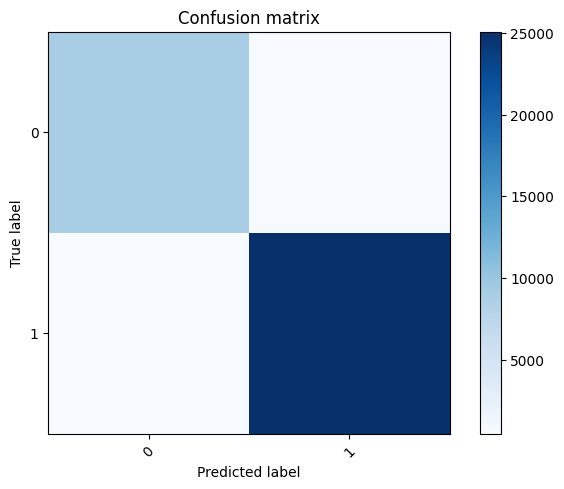

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      9624
           1       0.97      0.98      0.98     25554

    accuracy                           0.97     35178
   macro avg       0.96      0.96      0.96     35178
weighted avg       0.97      0.97      0.97     35178



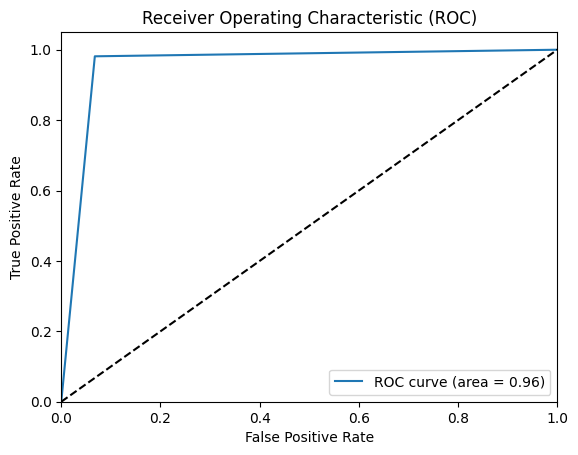

In [25]:
label = encode_text_index(test_df, "label")
pred = dnn_relu_adam_model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_true = np.argmax(y_test,axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)

print('Confusion matrix plot:')

plt.figure()
plot_confusion_matrix(cm, label)
plt.show()

print(classification_report(y_true, pred))

# Plot roc curve
plot_roc(pred,y_true)

## DNN Sigmoid with adam optimizer

In [26]:
# Saving best model
checkpointer = ModelCheckpoint(filepath=os.path.join(saved_path, "dnn_sigmoid_adam_model.keras"), 
                               verbose=0, save_best_only=True)
# Run for 3 times
for i in range(3):
    print('\nRun: ', i + 1)
    dnn_sigmoid_adam_model = Sequential()
    dnn_sigmoid_adam_model.add(Dense(50, input_dim=x_train.shape[1], activation='sigmoid')) # layer with activation sigmoid
    dnn_sigmoid_adam_model.add(Dense(25, activation='sigmoid')) # added layer 
    dnn_sigmoid_adam_model.add(Dense(y_train.shape[1], activation='softmax')) # output layer with softmax function
    
    # Compile using adam optimizer
    dnn_sigmoid_adam_model.compile(loss='categorical_crossentropy', optimizer='adam')

    # Stop training when model stops improving
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')

    dnn_sigmoid_adam_model.fit(x_train, y_train, validation_data=(x_test, y_test), callbacks=[monitor, checkpointer], verbose=2, epochs=1000)
    
print('Runs complete, saving model')  
print()
dnn_sigmoid_adam_model.load_weights(os.path.join(saved_path, 'dnn_sigmoid_adam_model.keras'))


Run:  1
Epoch 1/1000


/Users/yahir/anaconda3/envs/testenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2519/2519 - 2s - 672us/step - loss: 0.0903 - val_loss: 0.1309
Epoch 2/1000
2519/2519 - 1s - 485us/step - loss: 0.0477 - val_loss: 0.1284
Epoch 3/1000
2519/2519 - 1s - 466us/step - loss: 0.0434 - val_loss: 0.1028
Epoch 4/1000
2519/2519 - 1s - 461us/step - loss: 0.0420 - val_loss: 0.1133
Epoch 5/1000
2519/2519 - 1s - 459us/step - loss: 0.0410 - val_loss: 0.1195
Epoch 6/1000
2519/2519 - 1s - 463us/step - loss: 0.0400 - val_loss: 0.0819
Epoch 7/1000
2519/2519 - 1s - 458us/step - loss: 0.0393 - val_loss: 0.0925
Epoch 8/1000
2519/2519 - 1s - 458us/step - loss: 0.0391 - val_loss: 0.0954
Epoch 9/1000
2519/2519 - 1s - 457us/step - loss: 0.0382 - val_loss: 0.0904
Epoch 9: early stopping

Run:  2
Epoch 1/1000
2519/2519 - 2s - 666us/step - loss: 0.0940 - val_loss: 0.1228
Epoch 2/1000
2519/2519 - 1s - 463us/step - loss: 0.0479 - val_loss: 0.1245
Epoch 3/1000
2519/2519 - 1s - 462us/step - loss: 0.0438 - val_loss: 0.1263
Epoch 4/1000
2519/2519 - 1s - 461us/step - loss: 0.0419 - val_loss: 0.1119
Epoch

1100/1100 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step
[[ 8956   668]
 [  675 24879]]
Confusion matrix plot:


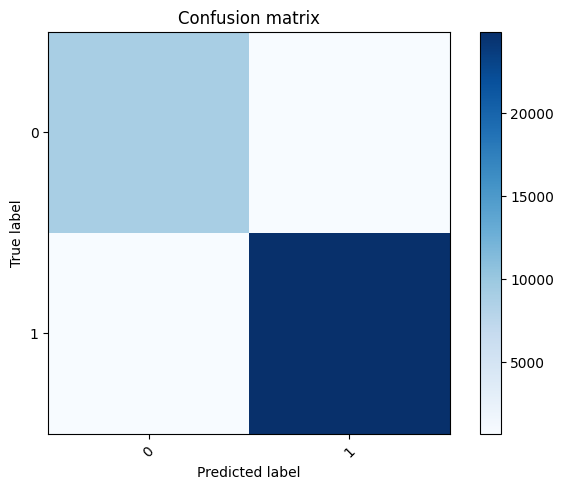

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      9624
           1       0.97      0.97      0.97     25554

    accuracy                           0.96     35178
   macro avg       0.95      0.95      0.95     35178
weighted avg       0.96      0.96      0.96     35178



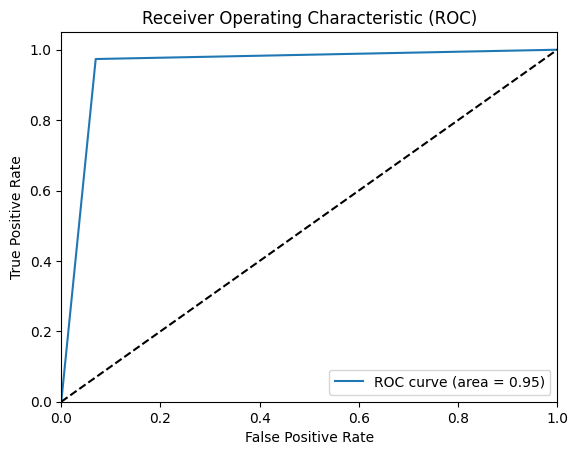

In [27]:
pred = dnn_sigmoid_adam_model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_true = np.argmax(y_test,axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)

print('Confusion matrix plot:')

plt.figure()
plot_confusion_matrix(cm, label)
plt.show()

print(classification_report(y_true, pred))

# Plot roc curve
plot_roc(pred,y_true)

## DNN Tanh with sgd optimizer

In [28]:
# Saving best model
checkpointer = ModelCheckpoint(filepath=os.path.join(saved_path, "dnn_tanh_sgd_model.keras"), 
                               verbose=0, save_best_only=True)
# Run for 3 times
for i in range(3):
    print('\nRun: ', i + 1)
    dnn_tanh_sgd_model = Sequential()
    dnn_tanh_sgd_model.add(Dense(40, input_dim=x_train.shape[1], activation='tanh')) # layer with activation tanh
    dnn_tanh_sgd_model.add(Dense(20, activation='tanh')) # added layer 
    dnn_tanh_sgd_model.add(Dense(y_train.shape[1], activation='softmax')) # output layer with softmax function
    
    # Compile using sgd optimizer
    dnn_tanh_sgd_model.compile(loss='categorical_crossentropy', optimizer='sgd')

    # Stop training when model stops improving
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')

    dnn_tanh_sgd_model.fit(x_train, y_train, validation_data=(x_test, y_test), callbacks=[monitor, checkpointer], verbose=2, epochs=1000)
    
print('Runs complete, saving model')  
print()
dnn_tanh_sgd_model.load_weights(os.path.join(saved_path, 'dnn_tanh_sgd_model.keras'))


Run:  1
Epoch 1/1000


/Users/yahir/anaconda3/envs/testenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2519/2519 - 1s - 478us/step - loss: 0.1010 - val_loss: 0.1675
Epoch 2/1000
2519/2519 - 1s - 402us/step - loss: 0.0660 - val_loss: 0.1530
Epoch 3/1000
2519/2519 - 1s - 402us/step - loss: 0.0591 - val_loss: 0.1338
Epoch 4/1000
2519/2519 - 1s - 400us/step - loss: 0.0530 - val_loss: 0.1365
Epoch 5/1000
2519/2519 - 1s - 402us/step - loss: 0.0480 - val_loss: 0.1307
Epoch 6/1000
2519/2519 - 1s - 403us/step - loss: 0.0450 - val_loss: 0.1083
Epoch 7/1000
2519/2519 - 1s - 401us/step - loss: 0.0434 - val_loss: 0.1235
Epoch 8/1000
2519/2519 - 1s - 402us/step - loss: 0.0423 - val_loss: 0.1082
Epoch 9/1000
2519/2519 - 1s - 459us/step - loss: 0.0415 - val_loss: 0.1033
Epoch 10/1000
2519/2519 - 1s - 403us/step - loss: 0.0409 - val_loss: 0.0981
Epoch 11/1000
2519/2519 - 1s - 400us/step - loss: 0.0403 - val_loss: 0.0907
Epoch 12/1000
2519/2519 - 1s - 403us/step - loss: 0.0400 - val_loss: 0.0835
Epoch 13/1000
2519/2519 - 1s - 397us/step - loss: 0.0395 - val_loss: 0.0877
Epoch 14/1000
2519/2519 - 1s - 397

1100/1100 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
[[ 9068   556]
 [  714 24840]]
Confusion matrix plot:


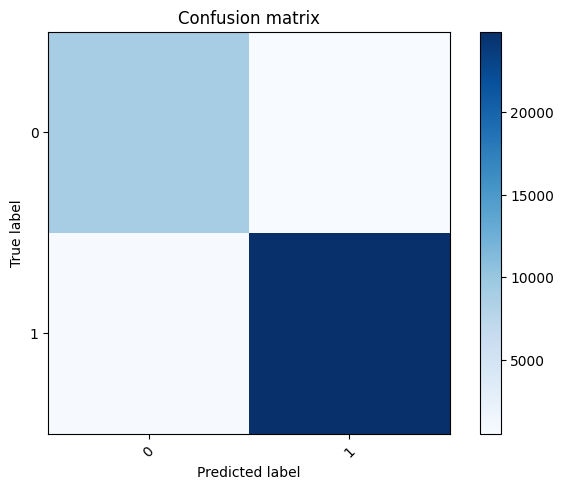

              precision    recall  f1-score   support

           0       0.93      0.94      0.93      9624
           1       0.98      0.97      0.98     25554

    accuracy                           0.96     35178
   macro avg       0.95      0.96      0.95     35178
weighted avg       0.96      0.96      0.96     35178



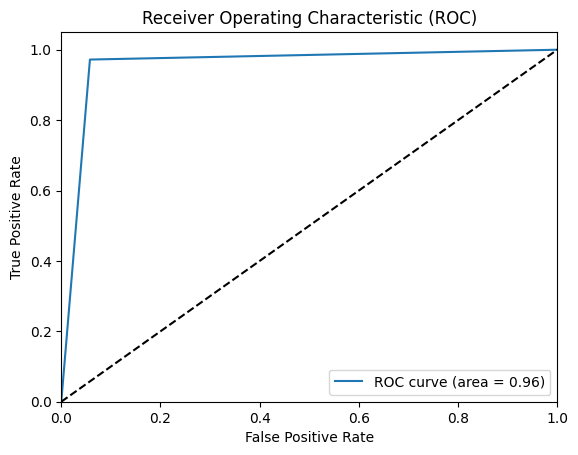

In [29]:
pred = dnn_tanh_sgd_model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_true = np.argmax(y_test,axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)

print('Confusion matrix plot:')

plt.figure()
plot_confusion_matrix(cm, label)
plt.show()

print(classification_report(y_true, pred))

# Plot roc curve
plot_roc(pred,y_true)

### <font color='red'><b>Reshaping for CNN models</b></font>

In [30]:
cnn_x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1], 1)
cnn_x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1], 1)

In [31]:
input_shape = (1, x_train.shape[1], 1)

## CNN Relu with adam optimizer

In [32]:
# Save beset model
checkpointer = ModelCheckpoint(filepath=os.path.join(saved_path, "cnn_relu_adam.keras"), verbose=0, save_best_only=True)

# Run for 3 times
for i in range(3):
    print('\nRun: ', i + 1)
    
    cnn_relu_adam = Sequential()
    # Adding first Conv2D layer
    cnn_relu_adam.add(Conv2D(32, kernel_size=(1, 5), strides=(2, 2), activation='relu', input_shape=input_shape))
    cnn_relu_adam.add(MaxPooling2D(pool_size=(1, 3), strides=(2, 2))) # Maxpooling to downsample
    cnn_relu_adam.add(Conv2D(64, (1, 5), activation='relu'))
    cnn_relu_adam.add(MaxPooling2D(pool_size=(1, 3), strides=(2, 2)))
    cnn_relu_adam.add(Flatten()) # Flatten the output for fully connected layers
    
    cnn_relu_adam.add(Dense(1000, activation='relu')) # Fully connected layer with 1000 units and relu activation
    cnn_relu_adam.add(Dropout(0.1)) # Dropout for regularization
    cnn_relu_adam.add(Dense(y_train.shape[1], activation='softmax')) # Output layer with softmax for classification 
    
     # Compile using adam optimizer
    cnn_relu_adam.compile(loss='categorical_crossentropy', optimizer='adam')
    # Stop once done improving
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
    cnn_relu_adam.fit(cnn_x_train, y_train, validation_data=(cnn_x_test, y_test), callbacks=[monitor, checkpointer], verbose=2, epochs=500)
    
    
print('Runs complete, saving model')  
print()
cnn_relu_adam.load_weights(os.path.join(saved_path, 'cnn_relu_adam.keras'))


Run:  1
Epoch 1/500


/Users/yahir/anaconda3/envs/testenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2519/2519 - 9s - 4ms/step - loss: 0.0592 - val_loss: 0.0888
Epoch 2/500
2519/2519 - 8s - 3ms/step - loss: 0.0417 - val_loss: 0.0958
Epoch 3/500
2519/2519 - 9s - 3ms/step - loss: 0.0387 - val_loss: 0.1066
Epoch 4/500
2519/2519 - 9s - 4ms/step - loss: 0.0374 - val_loss: 0.1276
Epoch 4: early stopping

Run:  2
Epoch 1/500
2519/2519 - 9s - 3ms/step - loss: 0.0599 - val_loss: 0.0813
Epoch 2/500
2519/2519 - 10s - 4ms/step - loss: 0.0421 - val_loss: 0.0949
Epoch 3/500
2519/2519 - 9s - 3ms/step - loss: 0.0394 - val_loss: 0.0822
Epoch 4/500
2519/2519 - 8s - 3ms/step - loss: 0.0383 - val_loss: 0.0847
Epoch 4: early stopping

Run:  3
Epoch 1/500
2519/2519 - 8s - 3ms/step - loss: 0.0608 - val_loss: 0.0859
Epoch 2/500
2519/2519 - 8s - 3ms/step - loss: 0.0418 - val_loss: 0.0837
Epoch 3/500
2519/2519 - 8s - 3ms/step - loss: 0.0398 - val_loss: 0.0773
Epoch 4/500
2519/2519 - 8s - 3ms/step - loss: 0.0373 - val_loss: 0.1020
Epoch 5/500
2519/2519 - 8s - 3ms/step - loss: 0.0373 - val_loss: 0.1256
Epoch 6/5

1100/1100 ━━━━━━━━━━━━━━━━━━━━ 1s 741us/step
[[ 8574  1050]
 [  208 25346]]
Confusion matrix plot:


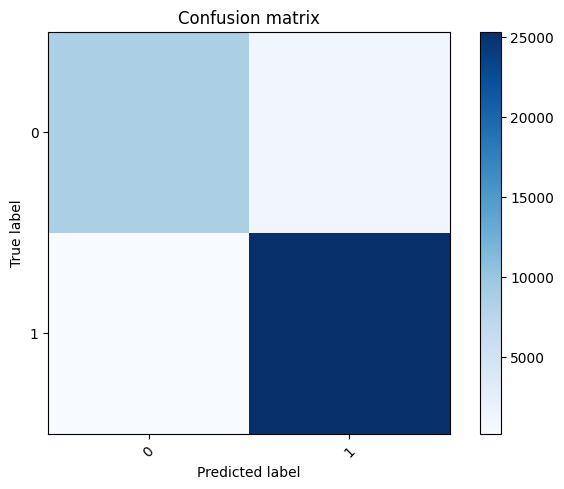

              precision    recall  f1-score   support

           0       0.98      0.89      0.93      9624
           1       0.96      0.99      0.98     25554

    accuracy                           0.96     35178
   macro avg       0.97      0.94      0.95     35178
weighted avg       0.96      0.96      0.96     35178



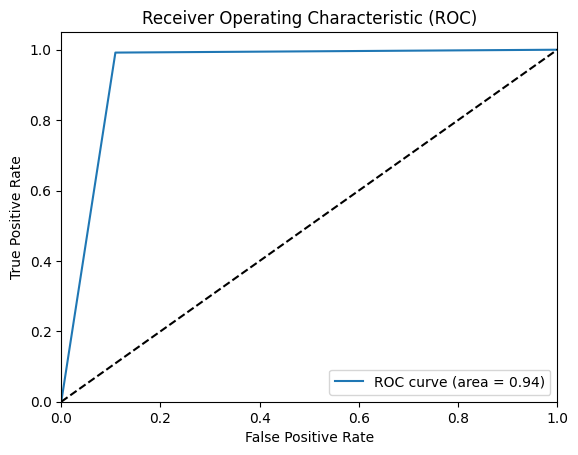

In [35]:
pred = cnn_relu_adam.predict(cnn_x_test)
pred = np.argmax(pred,axis=1)
y_true = np.argmax(y_test,axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)

print('Confusion matrix plot:')

plt.figure()
plot_confusion_matrix(cm, label)
plt.show()

print(classification_report(y_true, pred))

# Plot roc curve
plot_roc(pred,y_true)

## CNN Relu with sgd optimizer

In [36]:
checkpointer = ModelCheckpoint(filepath=os.path.join(saved_path, "cnn_relu_sgd.keras"), 
                               verbose=0, save_best_only=True)

for i in range(3):
    print('\nRun: ', i + 1)
    
    cnn_relu_sgd = Sequential()
    
    cnn_relu_sgd.add(Conv2D(128, kernel_size=(1, 3), strides=(1, 2), activation='relu', input_shape=input_shape))
    cnn_relu_sgd.add(MaxPooling2D(pool_size=(1, 2), strides=(1, 2)))
    cnn_relu_sgd.add(Conv2D(64, (1, 3), activation='relu'))
    cnn_relu_sgd.add(MaxPooling2D(pool_size=(1, 2), strides=(1, 2)))
    cnn_relu_sgd.add(Flatten())
    
    cnn_relu_sgd.add(Dense(800, activation='relu'))
    cnn_relu_sgd.add(Dropout(0.4))
    cnn_relu_sgd.add(Dense(y_train.shape[1], activation='softmax'))
    
    cnn_relu_sgd.compile(loss='categorical_crossentropy', optimizer='sgd')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
    cnn_relu_sgd.fit(cnn_x_train, y_train, validation_data=(cnn_x_test, y_test), callbacks=[monitor, checkpointer], verbose=2, epochs=500)
    
    
print('Runs complete, saving model')  
print()
cnn_relu_sgd.load_weights(os.path.join(saved_path, 'cnn_relu_sgd.keras'))


Run:  1
Epoch 1/500


/Users/yahir/anaconda3/envs/testenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2519/2519 - 9s - 4ms/step - loss: 0.1375 - val_loss: 0.2104
Epoch 2/500
2519/2519 - 9s - 4ms/step - loss: 0.0699 - val_loss: 0.1731
Epoch 3/500
2519/2519 - 9s - 4ms/step - loss: 0.0629 - val_loss: 0.1339
Epoch 4/500
2519/2519 - 10s - 4ms/step - loss: 0.0568 - val_loss: 0.1284
Epoch 5/500
2519/2519 - 9s - 4ms/step - loss: 0.0529 - val_loss: 0.1298
Epoch 6/500
2519/2519 - 9s - 4ms/step - loss: 0.0496 - val_loss: 0.0999
Epoch 7/500
2519/2519 - 10s - 4ms/step - loss: 0.0470 - val_loss: 0.0982
Epoch 8/500
2519/2519 - 8s - 3ms/step - loss: 0.0450 - val_loss: 0.1081
Epoch 9/500
2519/2519 - 9s - 4ms/step - loss: 0.0431 - val_loss: 0.0986
Epoch 10/500
2519/2519 - 9s - 3ms/step - loss: 0.0421 - val_loss: 0.0835
Epoch 11/500
2519/2519 - 9s - 4ms/step - loss: 0.0413 - val_loss: 0.0939
Epoch 12/500
2519/2519 - 9s - 3ms/step - loss: 0.0406 - val_loss: 0.0768
Epoch 13/500
2519/2519 - 9s - 3ms/step - loss: 0.0398 - val_loss: 0.0878
Epoch 14/500
2519/2519 - 10s - 4ms/step - loss: 0.0392 - val_loss: 0.0

1100/1100 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
[[ 9208   416]
 [  712 24842]]
Confusion matrix plot:


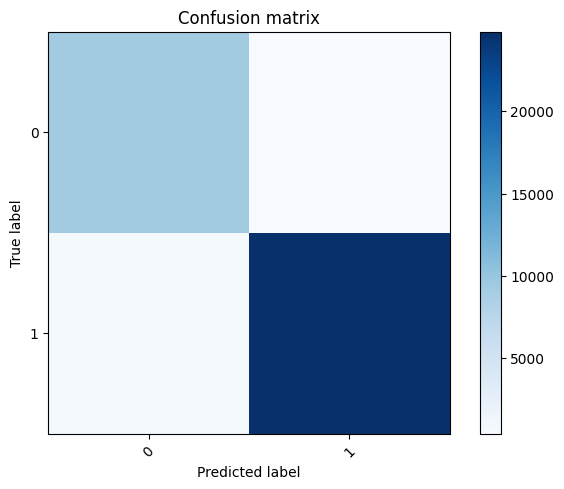

              precision    recall  f1-score   support

           0       0.93      0.96      0.94      9624
           1       0.98      0.97      0.98     25554

    accuracy                           0.97     35178
   macro avg       0.96      0.96      0.96     35178
weighted avg       0.97      0.97      0.97     35178



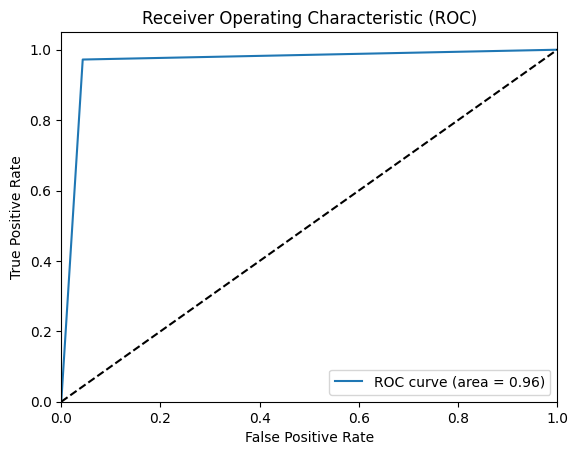

In [37]:
pred = cnn_relu_sgd.predict(cnn_x_test)
pred = np.argmax(pred,axis=1)
y_true = np.argmax(y_test,axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)

print('Confusion matrix plot:')

plt.figure()
plot_confusion_matrix(cm, label)
plt.show()

print(classification_report(y_true, pred))

# Plot roc curve
plot_roc(pred,y_true)

## CNN Sigmoid with adam optimizer

In [38]:
checkpointer = ModelCheckpoint(filepath=os.path.join(saved_path, "cnn_sigmoid_adam.keras"), verbose=0, save_best_only=True)

for i in range(3):
    print('\nRun: ', i + 1)
    
    cnn_sigmoid_adam = Sequential()
    
    cnn_sigmoid_adam.add(Conv2D(32, kernel_size=(1, 3), strides=(1, 1), activation='sigmoid', input_shape=input_shape))
    cnn_sigmoid_adam.add(MaxPooling2D(pool_size=(1, 4), strides=(2, 2)))
    cnn_sigmoid_adam.add(Conv2D(64, (1, 5), activation='sigmoid'))
    cnn_sigmoid_adam.add(MaxPooling2D(pool_size=(1, 4), strides=(3, 3)))
    cnn_sigmoid_adam.add(Flatten())
    
    cnn_sigmoid_adam.add(Dense(1000, activation='sigmoid'))
    cnn_sigmoid_adam.add(Dropout(0.2))
    cnn_sigmoid_adam.add(Dense(y_train.shape[1], activation='softmax'))
    
    cnn_sigmoid_adam.compile(loss='categorical_crossentropy', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
    cnn_sigmoid_adam.fit(cnn_x_train, y_train, validation_data=(cnn_x_test, y_test), callbacks=[monitor, checkpointer], verbose=2, epochs=500)
    
    
print('Runs complete, saving model')    
print()
cnn_sigmoid_adam.load_weights(os.path.join(saved_path, 'cnn_sigmoid_adam.keras'))


Run:  1
Epoch 1/500


/Users/yahir/anaconda3/envs/testenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2519/2519 - 14s - 5ms/step - loss: 0.1537 - val_loss: 0.1572
Epoch 2/500
2519/2519 - 13s - 5ms/step - loss: 0.0683 - val_loss: 0.1975
Epoch 3/500
2519/2519 - 14s - 5ms/step - loss: 0.0592 - val_loss: 0.1256
Epoch 4/500
2519/2519 - 15s - 6ms/step - loss: 0.0523 - val_loss: 0.1764
Epoch 5/500
2519/2519 - 12s - 5ms/step - loss: 0.0475 - val_loss: 0.1066
Epoch 6/500
2519/2519 - 12s - 5ms/step - loss: 0.0442 - val_loss: 0.1146
Epoch 7/500
2519/2519 - 12s - 5ms/step - loss: 0.0431 - val_loss: 0.0935
Epoch 8/500
2519/2519 - 13s - 5ms/step - loss: 0.0414 - val_loss: 0.0868
Epoch 9/500
2519/2519 - 13s - 5ms/step - loss: 0.0404 - val_loss: 0.0843
Epoch 10/500
2519/2519 - 12s - 5ms/step - loss: 0.0393 - val_loss: 0.0826
Epoch 11/500
2519/2519 - 12s - 5ms/step - loss: 0.0389 - val_loss: 0.0912
Epoch 12/500
2519/2519 - 13s - 5ms/step - loss: 0.0382 - val_loss: 0.0814
Epoch 13/500
2519/2519 - 13s - 5ms/step - loss: 0.0375 - val_loss: 0.1082
Epoch 14/500
2519/2519 - 12s - 5ms/step - loss: 0.0368 - va

1100/1100 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  
[[ 8860   764]
 [  588 24966]]
Confusion matrix plot:


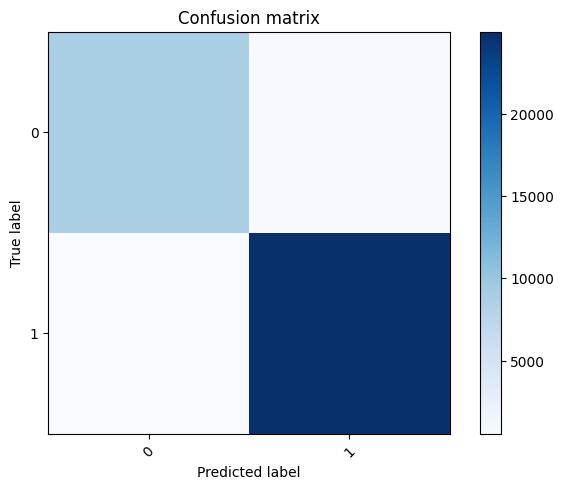

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      9624
           1       0.97      0.98      0.97     25554

    accuracy                           0.96     35178
   macro avg       0.95      0.95      0.95     35178
weighted avg       0.96      0.96      0.96     35178



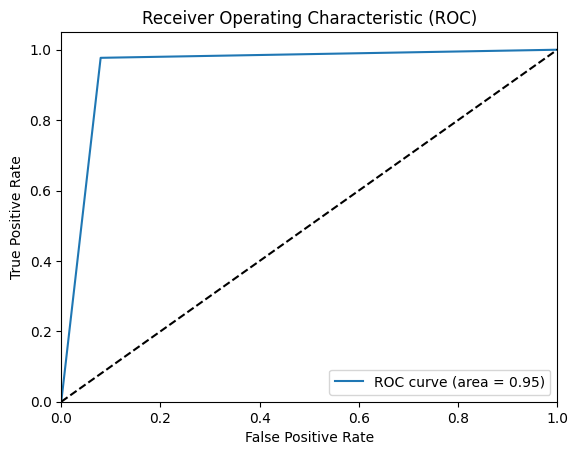

In [39]:
pred = cnn_sigmoid_adam.predict(cnn_x_test)
pred = np.argmax(pred,axis=1)
y_true = np.argmax(y_test,axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)

print('Confusion matrix plot:')

plt.figure()
plot_confusion_matrix(cm, label)
plt.show()

print(classification_report(y_true, pred))

# Plot roc curve
plot_roc(pred,y_true)

## CNN Sigmoid with sgd optimizer

In [40]:
checkpointer = ModelCheckpoint(filepath=os.path.join(saved_path, "cnn_sigmoid_sgd.keras"), 
                               verbose=0, save_best_only=True)

for i in range(3):
    print('\nRun: ', i + 1)
    
    cnn_sigmoid_sgd = Sequential()
    
    cnn_sigmoid_sgd.add(Conv2D(128, kernel_size=(1, 5), strides=(1, 1), activation='sigmoid', input_shape=input_shape))
    cnn_sigmoid_sgd.add(MaxPooling2D(pool_size=(1, 2), strides=(2, 2)))
    cnn_sigmoid_sgd.add(Conv2D(32, (1, 5), activation='sigmoid'))
    cnn_sigmoid_sgd.add(MaxPooling2D(pool_size=(1, 2), strides=(2, 2)))
    cnn_sigmoid_sgd.add(Flatten())
    cnn_sigmoid_sgd.add(Dense(1000, activation='sigmoid'))
    cnn_sigmoid_sgd.add(Dropout(0.5))
    cnn_sigmoid_sgd.add(Dense(y_train.shape[1], activation='softmax'))
    
    cnn_sigmoid_sgd.compile(loss='categorical_crossentropy', optimizer='sgd')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
    cnn_sigmoid_sgd.fit(cnn_x_train, y_train, validation_data=(cnn_x_test, y_test), callbacks=[monitor, checkpointer], verbose=2, epochs=500)
    
    
print('Runs complete, saving model')    
print()
cnn_sigmoid_sgd.load_weights(os.path.join(saved_path, 'cnn_sigmoid_sgd.keras'))


Run:  1
Epoch 1/500


/Users/yahir/anaconda3/envs/testenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2519/2519 - 15s - 6ms/step - loss: 0.5915 - val_loss: 0.6001
Epoch 2/500
2519/2519 - 14s - 6ms/step - loss: 0.5715 - val_loss: 0.6138
Epoch 3/500
2519/2519 - 15s - 6ms/step - loss: 0.5685 - val_loss: 0.6266
Epoch 4/500
2519/2519 - 15s - 6ms/step - loss: 0.5656 - val_loss: 0.6022
Epoch 4: early stopping

Run:  2
Epoch 1/500
2519/2519 - 15s - 6ms/step - loss: 0.5930 - val_loss: 0.5864
Epoch 2/500
2519/2519 - 15s - 6ms/step - loss: 0.5723 - val_loss: 0.5860
Epoch 3/500
2519/2519 - 17s - 7ms/step - loss: 0.5692 - val_loss: 0.5876
Epoch 4/500
2519/2519 - 16s - 6ms/step - loss: 0.5686 - val_loss: 0.5903
Epoch 4: early stopping

Run:  3
Epoch 1/500
2519/2519 - 15s - 6ms/step - loss: 0.5926 - val_loss: 0.5901
Epoch 2/500
2519/2519 - 15s - 6ms/step - loss: 0.5710 - val_loss: 0.6139
Epoch 3/500
2519/2519 - 15s - 6ms/step - loss: 0.5689 - val_loss: 0.5874
Epoch 4/500
2519/2519 - 13s - 5ms/step - loss: 0.5663 - val_loss: 0.5963
Epoch 5/500
2519/2519 - 13s - 5ms/step - loss: 0.5631 - val_loss: 0.57

1100/1100 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
[[ 6657  2967]
 [   30 25524]]
Confusion matrix plot:


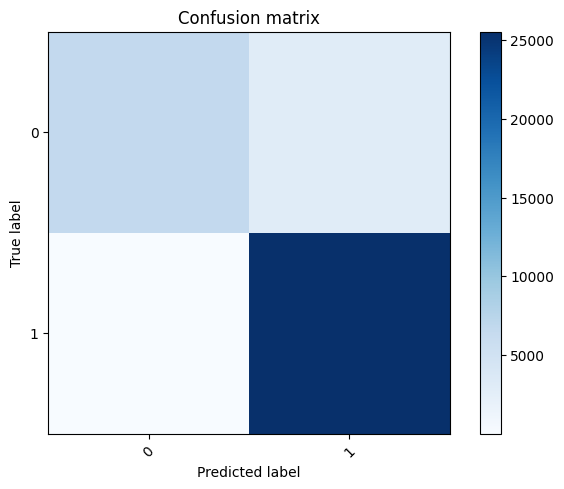

              precision    recall  f1-score   support

           0       1.00      0.69      0.82      9624
           1       0.90      1.00      0.94     25554

    accuracy                           0.91     35178
   macro avg       0.95      0.85      0.88     35178
weighted avg       0.92      0.91      0.91     35178



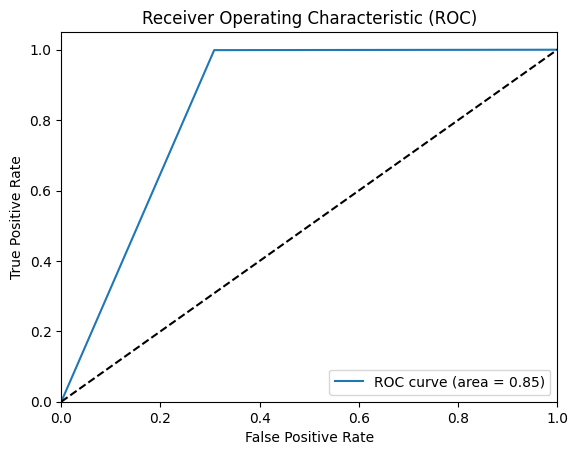

In [41]:
pred = cnn_sigmoid_sgd.predict(cnn_x_test)
pred = np.argmax(pred,axis=1)
y_true = np.argmax(y_test,axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)

print('Confusion matrix plot:')

plt.figure()
plot_confusion_matrix(cm, label)
plt.show()

print(classification_report(y_true, pred))

# Plot roc curve
plot_roc(pred,y_true)

## CNN Tanh with adam optimizer

In [43]:
checkpointer = ModelCheckpoint(filepath=os.path.join(saved_path, "cnn_tanh_adam.keras"), 
                               verbose=0, save_best_only=True)

for i in range(3):
    print('\nRun: ', i + 1)
    
    cnn_tanh_adam = Sequential()
    
    cnn_tanh_adam.add(Conv2D(64, kernel_size=(1, 6), strides=(1, 1), activation='tanh', input_shape=input_shape))
    cnn_tanh_adam.add(MaxPooling2D(pool_size=(1, 3), strides=(2, 2)))
    cnn_tanh_adam.add(Conv2D(64, (1, 5), activation='tanh'))
    cnn_tanh_adam.add(MaxPooling2D(pool_size=(1, 3), strides=(2, 2)))
    cnn_tanh_adam.add(Flatten())
    cnn_tanh_adam.add(Dense(1000, activation='tanh'))
    cnn_tanh_adam.add(Dropout(0.2))
    cnn_tanh_adam.add(Dense(y_train.shape[1], activation='softmax'))
    
     # Use categorical crossentropy loss since it is a classification problem
    cnn_tanh_adam.compile(loss='categorical_crossentropy', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
    cnn_tanh_adam.fit(cnn_x_train, y_train, validation_data=(cnn_x_test, y_test), callbacks=[monitor, checkpointer], verbose=2, epochs=500)
    
    
print('Runs complete, saving model')    
print()
cnn_tanh_adam.load_weights(os.path.join(saved_path, 'cnn_tanh_adam.keras'))


Run:  1
Epoch 1/500
2519/2519 - 23s - 9ms/step - loss: 0.0601 - val_loss: 0.1304
Epoch 2/500
2519/2519 - 22s - 9ms/step - loss: 0.0463 - val_loss: 0.0843
Epoch 3/500
2519/2519 - 19s - 8ms/step - loss: 0.0439 - val_loss: 0.1026
Epoch 4/500
2519/2519 - 19s - 8ms/step - loss: 0.0421 - val_loss: 0.0737
Epoch 5/500
2519/2519 - 18s - 7ms/step - loss: 0.0411 - val_loss: 0.0883
Epoch 6/500
2519/2519 - 19s - 8ms/step - loss: 0.0404 - val_loss: 0.1329
Epoch 7/500
2519/2519 - 19s - 7ms/step - loss: 0.0399 - val_loss: 0.0777
Epoch 7: early stopping

Run:  2
Epoch 1/500
2519/2519 - 18s - 7ms/step - loss: 0.0608 - val_loss: 0.1535
Epoch 2/500
2519/2519 - 18s - 7ms/step - loss: 0.0465 - val_loss: 0.1529
Epoch 3/500
2519/2519 - 18s - 7ms/step - loss: 0.0433 - val_loss: 0.1216
Epoch 4/500
2519/2519 - 18s - 7ms/step - loss: 0.0411 - val_loss: 0.1069
Epoch 5/500
2519/2519 - 18s - 7ms/step - loss: 0.0411 - val_loss: 0.0971
Epoch 6/500
2519/2519 - 18s - 7ms/step - loss: 0.0398 - val_loss: 0.1278
Epoch 7/5

1100/1100 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
[[ 8794   830]
 [  341 25213]]
Confusion matrix plot:


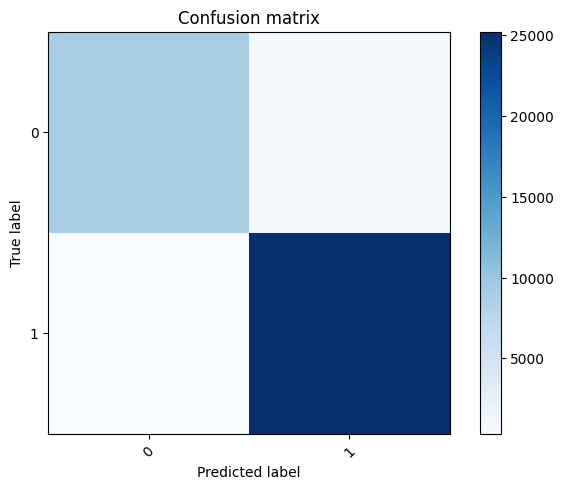

              precision    recall  f1-score   support

           0       0.96      0.91      0.94      9624
           1       0.97      0.99      0.98     25554

    accuracy                           0.97     35178
   macro avg       0.97      0.95      0.96     35178
weighted avg       0.97      0.97      0.97     35178



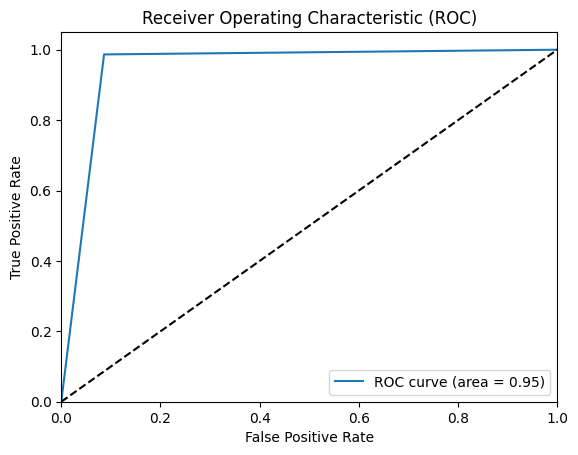

In [44]:
pred = cnn_tanh_adam.predict(cnn_x_test)
pred = np.argmax(pred,axis=1)
y_true = np.argmax(y_test,axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)

print('Confusion matrix plot:')

plt.figure()
plot_confusion_matrix(cm, label)
plt.show()

print(classification_report(y_true, pred))

# Plot roc curve
plot_roc(pred,y_true)

## CNN Tanh with sgd optimizer

In [45]:
checkpointer = ModelCheckpoint(filepath=os.path.join(saved_path, "cnn_tanh_sgd.keras"), 
                               verbose=0, save_best_only=True)

for i in range(3):
    print('\nRun: ', i + 1)
    
    cnn_tanh_sgd = Sequential()
    
    cnn_tanh_sgd.add(Conv2D(128, kernel_size=(1, 6), strides=(1, 3), activation='tanh', input_shape=input_shape))
    cnn_tanh_sgd.add(MaxPooling2D(pool_size=(1, 3), strides=(2, 2)))
    cnn_tanh_sgd.add(Conv2D(64, (1, 5), activation='tanh'))
    cnn_tanh_sgd.add(MaxPooling2D(pool_size=(1, 3), strides=(2, 2)))
    cnn_tanh_sgd.add(Flatten())
    cnn_tanh_sgd.add(Dense(1000, activation='tanh'))
    cnn_tanh_sgd.add(Dropout(0.5))
    cnn_tanh_sgd.add(Dense(y_train.shape[1], activation='softmax'))
    
     # Use categorical crossentropy loss since it is a classification problem
    cnn_tanh_sgd.compile(loss='categorical_crossentropy', optimizer='sgd')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
    cnn_tanh_sgd.fit(cnn_x_train, y_train, validation_data=(cnn_x_test, y_test), callbacks=[monitor, checkpointer], verbose=2, epochs=500)
    
    
print('Runs complete, saving model')   
print()
cnn_tanh_sgd.load_weights(os.path.join(saved_path, 'cnn_tanh_sgd.keras'))


Run:  1
Epoch 1/500


/Users/yahir/anaconda3/envs/testenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2519/2519 - 6s - 3ms/step - loss: 0.1265 - val_loss: 0.1783
Epoch 2/500
2519/2519 - 7s - 3ms/step - loss: 0.0673 - val_loss: 0.1701
Epoch 3/500
2519/2519 - 7s - 3ms/step - loss: 0.0562 - val_loss: 0.1349
Epoch 4/500
2519/2519 - 7s - 3ms/step - loss: 0.0495 - val_loss: 0.1144
Epoch 5/500
2519/2519 - 6s - 2ms/step - loss: 0.0455 - val_loss: 0.1774
Epoch 6/500
2519/2519 - 7s - 3ms/step - loss: 0.0437 - val_loss: 0.1000
Epoch 7/500
2519/2519 - 7s - 3ms/step - loss: 0.0419 - val_loss: 0.1395
Epoch 8/500
2519/2519 - 7s - 3ms/step - loss: 0.0410 - val_loss: 0.1345
Epoch 9/500
2519/2519 - 7s - 3ms/step - loss: 0.0404 - val_loss: 0.0763
Epoch 10/500
2519/2519 - 6s - 2ms/step - loss: 0.0396 - val_loss: 0.0750
Epoch 11/500
2519/2519 - 7s - 3ms/step - loss: 0.0389 - val_loss: 0.1029
Epoch 12/500
2519/2519 - 7s - 3ms/step - loss: 0.0381 - val_loss: 0.0738
Epoch 13/500
2519/2519 - 7s - 3ms/step - loss: 0.0382 - val_loss: 0.0693
Epoch 14/500
2519/2519 - 6s - 2ms/step - loss: 0.0375 - val_loss: 0.1290

1100/1100 ━━━━━━━━━━━━━━━━━━━━ 1s 866us/step
[[ 9154   470]
 [  528 25026]]
Confusion matrix plot:


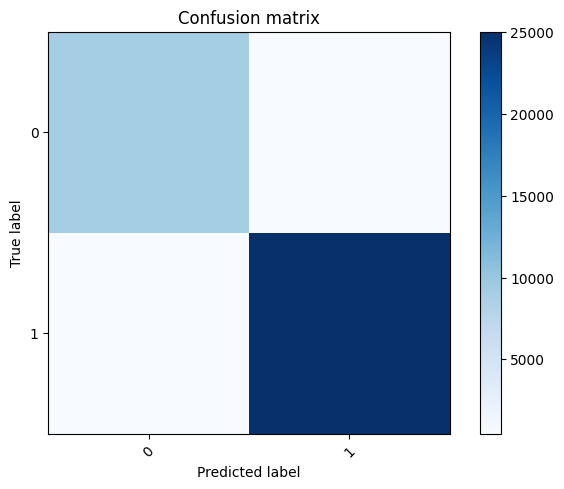

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      9624
           1       0.98      0.98      0.98     25554

    accuracy                           0.97     35178
   macro avg       0.96      0.97      0.96     35178
weighted avg       0.97      0.97      0.97     35178



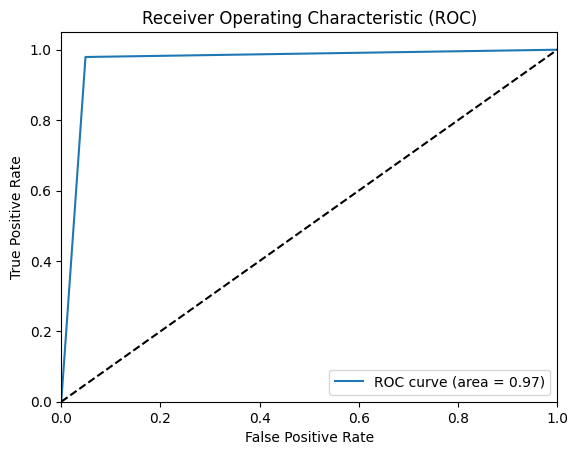

In [46]:
pred = cnn_tanh_sgd.predict(cnn_x_test)
pred = np.argmax(pred,axis=1)
y_true = np.argmax(y_test,axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)

print('Confusion matrix plot:')

plt.figure()
plot_confusion_matrix(cm, label)
plt.show()

print(classification_report(y_true, pred))

# Plot roc curve
plot_roc(pred,y_true)

# Determining best model

In [47]:
# Function to predict and calculate F1 score
def evaluate_model(model, x_test, y_true, is_cnn=True):
    if not is_cnn:
        # Flatten the data for DNNs if the input is not already 2D
        if x_test.ndim > 2:
            x_test = x_test.reshape(x_test.shape[0], -1)
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_true, axis=1)
    f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
    return f1

# Models dictionary to store F1 scores
models = {
    'dnn_relu_adam_model': {'model': dnn_relu_adam_model, 'is_cnn': False},
    'dnn_sigmoid_adam_model': {'model': dnn_sigmoid_adam_model, 'is_cnn': False},
    'dnn_tanh_sgd_model': {'model': dnn_tanh_sgd_model, 'is_cnn': False},
    'cnn_relu_adam': {'model': cnn_relu_adam, 'is_cnn': True},
    'cnn_relu_sgd': {'model': cnn_relu_sgd, 'is_cnn': True},
    'cnn_sigmoid_adam': {'model': cnn_sigmoid_adam, 'is_cnn': True},
    'cnn_sigmoid_sgd': {'model': cnn_sigmoid_sgd, 'is_cnn': True},
    'cnn_tanh_adam': {'model': cnn_tanh_adam, 'is_cnn': True},
    'cnn_tanh_sgd': {'model': cnn_tanh_sgd, 'is_cnn': True}
}

f1_scores = {}

# Evaluate each model and store F1 score
for name, info in models.items():
    f1 = evaluate_model(info['model'], cnn_x_test, y_test, is_cnn=info['is_cnn'])
    f1_scores[name] = f1
    print(f"F1 Score for {name}: {f1:.4f}")

# Determine model with best F1 score
best_model = max(f1_scores, key=f1_scores.get)
print(f"\nBest model is {best_model} with an F1 Score of {f1_scores[best_model]:.4f}")


1100/1100 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step
F1 Score for dnn_relu_adam_model: 0.9678
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step
F1 Score for dnn_sigmoid_adam_model: 0.9618
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step
F1 Score for dnn_tanh_sgd_model: 0.9640
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 1s 717us/step
F1 Score for cnn_relu_adam: 0.9637
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
F1 Score for cnn_relu_sgd: 0.9681
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
F1 Score for cnn_sigmoid_adam: 0.9615
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
F1 Score for cnn_sigmoid_sgd: 0.9094
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
F1 Score for cnn_tanh_adam: 0.9664
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 1s 862us/step
F1 Score for cnn_tanh_sgd: 0.9717

Best model is cnn_tanh_sgd with an F1 Score of 0.9717
